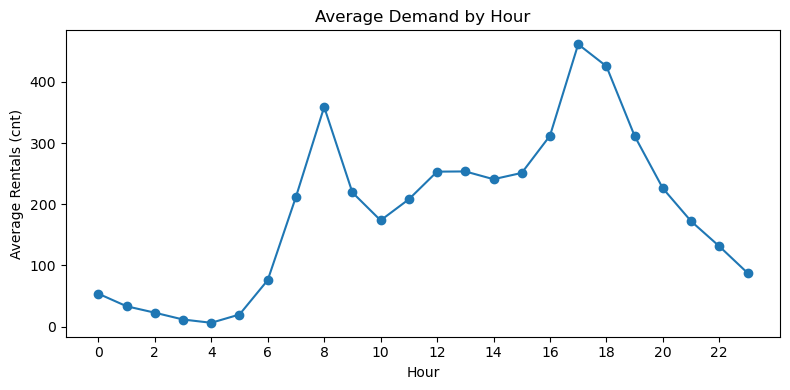

Top hours (avg cnt):
 hour
17    461.452055
18    425.510989
8     359.011004
Name: cnt, dtype: float64

Lowest hours (avg cnt):
 hour
4     6.352941
3    11.727403
5    19.889819
Name: cnt, dtype: float64


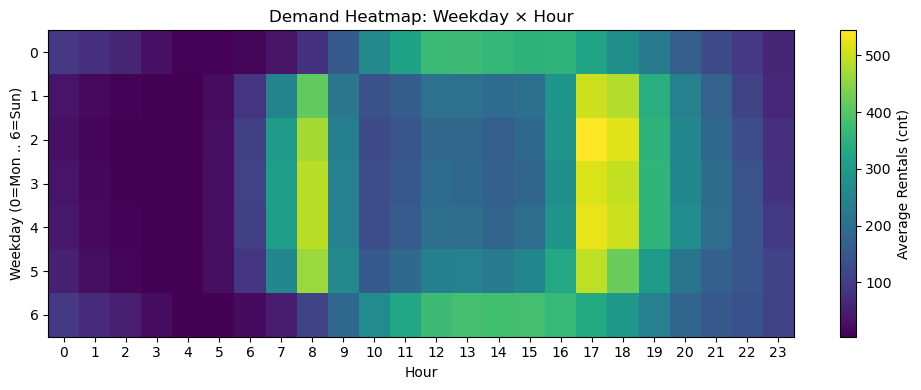

Heatmap stats — max cell: 544.3, min cell: 4.2


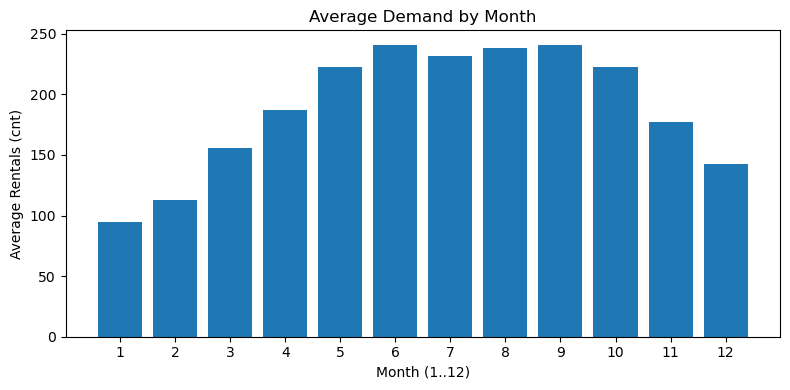

Top months (avg cnt):
 month
9    240.773138
6    240.515278
8    238.097627
Name: cnt, dtype: float64

Lowest months (avg cnt):
 month
1      94.424773
2     112.865026
12    142.303439
Name: cnt, dtype: float64

Quick Findings (edit these after you look at the plots):
• Peak hours show up around commute times (typically ~7–9 and ~17–19 on working days).
• Weekends tend to have a flatter afternoon peak (early afternoon).
• Monthly seasonality suggests warmer months carry higher demand (region-dependent).

Saved figures → figs/hourly_profile.png, figs/weekday_hour_heatmap.png, figs/monthly_seasonality.png


In [1]:
"""
Bike Sharing Demand — Mini EDA (Hourly Profile, Weekday×Hour Heatmap, Monthly Seasonality)
-----------------------------------------------------------------------------------------
• Keeps it simple: pandas + matplotlib (no seaborn).
• Human-style comments; you can run this as a script or paste cells into a notebook.
• Assumes a UCI Bike Sharing `hour.csv`-style dataset (or similar) with columns:
    - date or dteday (daily date),
    - hour (0..23),
    - weekday (0=Mon .. 6=Sun),
    - mnth (1..12) or month,
    - cnt (total rentals per hour).

Outputs (saved under ./figs/):
    - figs/hourly_profile.png
    - figs/weekday_hour_heatmap.png
    - figs/monthly_seasonality.png

If your CSV uses slightly different names, the code tries to map common variants.
"""

from __future__ import annotations
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 0) Config — set your CSV path
# ------------------------------
CSV_PATH = "hour.csv"   # change this to your actual path if needed
OUT_DIR = "figs"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------------------------------
# 1) Load data + light column normalization
# ---------------------------------------
# Why: real-world CSVs love tiny naming differences. We normalize sparingly
# so your analysis doesn't break just because someone wrote `mnth` instead of `month`.

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Put your hour.csv next to this file or update CSV_PATH.")

# Read CSV. If your date column is named differently, we'll handle it below.
df = pd.read_csv(CSV_PATH)

# Strip accidental spaces from column names (peeking at you, messy exports)
df.columns = [c.strip() for c in df.columns]

# Map a couple of common variants to the names we expect to use later
rename_map = {
    "dteday": "date",
    "instant": "row_id",
    "hr": "hour",
}
if "mnth" in df.columns and "month" not in df.columns:
    rename_map["mnth"] = "month"

df = df.rename(columns=rename_map)

# Basic sanity: do we have the must-have columns?
required = {"date", "hour", "weekday", "cnt"}
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}. Columns present: {list(df.columns)}")

# Make sure date is a proper datetime (some datasets keep it as string)
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# If month is missing, derive from date. (Some files already have `month` or `mnth`.)
if "month" not in df.columns:
    df["month"] = df["date"].dt.month

# Quick sanity checks — nothing fancy, just to catch footguns early.
if df["hour"].min() < 0 or df["hour"].max() > 23:
    raise ValueError("`hour` must be in 0..23. Check your data.")

if (df[["cnt"]] < 0).any().any():
    print("Warning: negative cnt values found. Keeping them, but this is unusual.")

# Optional: verify cnt ≈ casual + registered if those columns exist
if {"casual", "registered"}.issubset(df.columns):
    mismatch = (df["casual"] + df["registered"] != df["cnt"]).sum()
    if mismatch:
        print(f"Note: {mismatch} rows where cnt != casual + registered. Not fatal, just FYI.")

# ---------------------------
# 2) Hourly profile (0..23h)
# ---------------------------
# What: The "typical" rentals per hour of day, across the whole dataset.
# Why: This is the simplest, most readable picture of commuting peaks.

hourly = df.groupby("hour")["cnt"].mean().reindex(range(24))

# Plot — one clean figure, no special styles/colors.
plt.figure(figsize=(8, 4))
plt.plot(hourly.index, hourly.values, marker="o")
plt.title("Average Demand by Hour")
plt.xlabel("Hour")
plt.ylabel("Average Rentals (cnt)")
plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "hourly_profile.png"), dpi=200)
plt.show()

# A tiny textual readout that’s actually useful in a README or commit message
top3_hours = hourly.sort_values(ascending=False).head(3)
low3_hours = hourly.sort_values(ascending=True).head(3)
print("Top hours (avg cnt):\n", top3_hours)
print("\nLowest hours (avg cnt):\n", low3_hours)

# ---------------------------------------
# 3) Weekday × Hour heatmap (7 × 24 grid)
# ---------------------------------------
# What: Average cnt for each day-of-week and hour combo.
# Why: Highlights commute peaks on working days vs flatter weekends.

# Ensure we have all 7 days and 24 hours in the final matrix.
mat = (df.groupby(["weekday", "hour"])['cnt']
         .mean()
         .unstack("hour")
         .reindex(index=range(7), columns=range(24))
         .fillna(0))

plt.figure(figsize=(10, 4))
plt.imshow(mat.values, aspect="auto")
plt.title("Demand Heatmap: Weekday × Hour")
plt.xlabel("Hour")
plt.ylabel("Weekday (0=Mon .. 6=Sun)")
plt.colorbar(label="Average Rentals (cnt)")
plt.xticks(range(24), range(24))
plt.yticks(range(7), [0,1,2,3,4,5,6])  # keep numeric labels; simple and unambiguous
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "weekday_hour_heatmap.png"), dpi=200)
plt.show()

# Optional quick stats, because charts + a little text = better than charts alone.
max_val = float(np.nanmax(mat.values))
min_val = float(np.nanmin(mat.values))
print(f"Heatmap stats — max cell: {max_val:.1f}, min cell: {min_val:.1f}")

# ---------------------------------
# 4) Monthly seasonality (1..12)
# ---------------------------------
# What: Average cnt per month across all years.
# Why: A quick view of seasonal lift (warmer months tend to be higher).

monthly = df.groupby("month")["cnt"].mean().reindex(range(1, 13))

plt.figure(figsize=(8, 4))
plt.bar(monthly.index, monthly.values)
plt.title("Average Demand by Month")
plt.xlabel("Month (1..12)")
plt.ylabel("Average Rentals (cnt)")
plt.xticks(range(1, 13))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "monthly_seasonality.png"), dpi=200)
plt.show()

print("Top months (avg cnt):\n", monthly.sort_values(ascending=False).head(3))
print("\nLowest months (avg cnt):\n", monthly.sort_values(ascending=True).head(3))

# -----------------------------------------------------------
# 5) Mini wrap-up (plain-text placeholders you can rewrite)
# -----------------------------------------------------------
# Keep these human. They’re just a nudge so you don’t forget to summarize.

summary_lines = [
    "• Peak hours show up around commute times (typically ~7–9 and ~17–19 on working days).",
    "• Weekends tend to have a flatter afternoon peak (early afternoon).",
    "• Monthly seasonality suggests warmer months carry higher demand (region-dependent).",
]
print("\nQuick Findings (edit these after you look at the plots):")
for s in summary_lines:
    print(s)

print(f"\nSaved figures → {OUT_DIR}/hourly_profile.png, {OUT_DIR}/weekday_hour_heatmap.png, {OUT_DIR}/monthly_seasonality.png")
